# Mapping the largest Holocene Volcanic Eruptions (take 2)

This notebook is an update of my dated blog post (https://scottyhq.github.io/blog/2014/02/08/mapping-volcanic-eruptions/) illustrating some great new tools

The goal is to generate a map of major Holocene volcanic eruptions. Data is from the Smithsonian Global Volcanism Program. Recently the website was updated with improved search tools and the ability to download database search results to .csv format. We will search the eruptions database for volcano explosivity index (VEI) greater than 4. This index is a measure of the magnitude of an explosive volcanic eruption, and can be converted to erupted volume on a logarithmic scale.

Note that Smithsonian has released some great tools recently, including a GeoServer to query data programmatically:
http://volcano.si.edu/database/webservices.cfm. Previously, you had to manually search and download excel files, so this change is great for us programmers!

In [106]:
import matplotlib.pyplot as plt # For plotting
import owslib # For getting data from Smithsonian's geoserver
import cartopy # For plotting maps
import pandas as pd # For working with tabular data
import geopandas as pd # For geocoded tabular data
from io import StringIO #Needed to avoid saving to csv file
%matplotlib inline
#%qtconsole

ModuleNotFoundError: No module named 'geopandas'

In [43]:
# Connect to Smithsonian Geoserver, list contents
wfs = owslib.wfs.WebFeatureService(url='https://webservices.volcano.si.edu/geoserver/GVP-VOTW/wfs', version='1.1.0')
list(wfs.contents)

['GVP-VOTW:E3WebApp_EmissionPixels',
 'GVP-VOTW:E3WebApp_Emissions',
 'GVP-VOTW:E3WebApp_Eruptions1960',
 'GVP-VOTW:E3WebApp_HoloceneVolcanoes',
 'GVP-VOTW:GVP_Placemarks',
 'GVP-VOTW:Smithsonian VOTW Holocene Volcanoes',
 'GVP-VOTW:sivolcanodata',
 'GVP-VOTW:VOTW_Holocene_Volcanoes',
 'GVP-VOTW:VOTW_Holocene_Eruptions (test)',
 'GVP-VOTW:VOTW_Pleistocene_Volcanoes']

In [44]:
# How many Holocene volcanoes are in the VOTW?
# Read entire volcano list directly from server
from io import StringIO #Needed to avoid saving to csv file
typename = 'GVP-VOTW:VOTW_Holocene_Volcanoes'
output = 'csv'
response = wfs.getfeature(typename=typename, outputFormat=output)
df = pd.read_csv(StringIO(response.read()))
print('# Holocene Volcanoes=', len(df))

# Holocene Volcanoes= 1439


In [45]:
# Query by bounding box for particular region
# (left, bottom, right, top) in the feature type's coordinates == (minx, miny, maxx, maxy)
typename = 'GVP-VOTW:VOTW_Holocene_Volcanoes'
bbox = (-80, 0, -75, 6)
output = 'csv'
csvname = 'votw-bbox.csv'
response = wfs.getfeature(typename=typename, bbox=bbox, outputFormat=output)

with open(csvname, 'w') as out:
    out.write(response.read())

In [47]:
# Take a quick look at the first entries
print('Entries= ', len(df))
df = pd.read_csv(csvname)
df.head()

Entries=  22


,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
0,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351011,Romeral,Stratovolcano,-5390.0,Colombia,Recent work has documented the northernmost Ho...,South America,Colombia,5.203,-75.363,3769,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/117087.jpg,"Romeral, a recently documented Holocene volcan...",NASA Landsat7 image (worldwind.arc.nasa.gov),Andesite / Basaltic Andesite,POINT (5.203 -75.363)
1,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351012,"Bravo, Cerro",Stratovolcano,1720.0,Colombia,Cerro Bravo is a relatively low dominantly dac...,South America,Colombia,5.091,-75.293,3985,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/100084.jpg,Cerro Bravo is seen from Delgaditas on its eas...,"Photo by David Lescinsky, 1988 (University of ...",Dacite,POINT (5.091 -75.293)
2,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351021,Santa Isabel,Shield,-850.0,Colombia,Santa Isabel is a small andesitic shield volca...,South America,Colombia,4.818,-75.365,4944,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/043066.jpg,"Santa Isabel is a small, glacier-clad shield v...","Photo by Norm Banks, 1985 (U.S. Geological Sur...",Andesite / Basaltic Andesite,POINT (4.818 -75.365)
3,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351020,"Ruiz, Nevado del",Stratovolcano,2017.0,Colombia,"Nevado del Ruiz is a broad, glacier-covered vo...",South America,Colombia,4.892,-75.324,5279,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/043059.jpg,"Nevado del Ruiz is a broad, glacier-covered sh...","Photo by Norm Banks, 1985 (U.S. Geological Sur...",Andesite / Basaltic Andesite,POINT (4.892 -75.324)
4,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351030,"Tolima, Nevado del",Stratovolcano,1943.0,Colombia,"The steep-sided, glacier-clad Nevado del Tolim...",South America,Colombia,4.658,-75.330,5215,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/043069.jpg,"The steep-sided, glacier-clad Tolima volcano i...","Photo by Tom Pierson, 1985 (U.S. Geological Su...",Andesite / Basaltic Andesite,POINT (4.658 -75.33)


In [50]:
# Instead of filtering by bounding box, use a filter:
query = owslib.fes.PropertyIsEqualTo(propertyname='Subregion', literal='Colombia', matchcase=True)
querystr = owslib.etree.etree.tostring(query.toXML()).decode("utf-8")

response = wfs.getfeature(typename=typename, outputFormat=output, filter=querystr)
df = pd.read_csv(StringIO(response.read()))

In [51]:
print('Entries= ', len(df))
df = pd.read_csv(csvname)
df.head()

Entries=  15


,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
0,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351011,Romeral,Stratovolcano,-5390.0,Colombia,Recent work has documented the northernmost Ho...,South America,Colombia,5.203,-75.363,3769,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/117087.jpg,"Romeral, a recently documented Holocene volcan...",NASA Landsat7 image (worldwind.arc.nasa.gov),Andesite / Basaltic Andesite,POINT (5.203 -75.363)
1,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351012,"Bravo, Cerro",Stratovolcano,1720.0,Colombia,Cerro Bravo is a relatively low dominantly dac...,South America,Colombia,5.091,-75.293,3985,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/100084.jpg,Cerro Bravo is seen from Delgaditas on its eas...,"Photo by David Lescinsky, 1988 (University of ...",Dacite,POINT (5.091 -75.293)
2,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351021,Santa Isabel,Shield,-850.0,Colombia,Santa Isabel is a small andesitic shield volca...,South America,Colombia,4.818,-75.365,4944,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/043066.jpg,"Santa Isabel is a small, glacier-clad shield v...","Photo by Norm Banks, 1985 (U.S. Geological Sur...",Andesite / Basaltic Andesite,POINT (4.818 -75.365)
3,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351020,"Ruiz, Nevado del",Stratovolcano,2017.0,Colombia,"Nevado del Ruiz is a broad, glacier-covered vo...",South America,Colombia,4.892,-75.324,5279,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/043059.jpg,"Nevado del Ruiz is a broad, glacier-covered sh...","Photo by Norm Banks, 1985 (U.S. Geological Sur...",Andesite / Basaltic Andesite,POINT (4.892 -75.324)
4,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,351030,"Tolima, Nevado del",Stratovolcano,1943.0,Colombia,"The steep-sided, glacier-clad Nevado del Tolim...",South America,Colombia,4.658,-75.330,5215,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/043069.jpg,"The steep-sided, glacier-clad Tolima volcano i...","Photo by Tom Pierson, 1985 (U.S. Geological Su...",Andesite / Basaltic Andesite,POINT (4.658 -75.33)


In [63]:
# Load the eruptions database (much bigger)
# Get Global Eruptions with VEI>4
query = owslib.fes.PropertyIsGreaterThanOrEqualTo(propertyname='ExplosivityIndexMax', literal='4')
querystr = owslib.etree.etree.tostring(query.toXML()).decode("utf-8")

typename = 'GVP-VOTW:VOTW_Holocene_Eruptions (test)'
output = 'csv'
response = wfs.getfeature(typename=typename, outputFormat=output, filter=querystr)
df = pd.read_csv(StringIO(response.read()))

In [64]:
print('Entries= ', len(df))
df.head()
print(df.keys())

Entries=  741
Index(['FID', 'Volcano_Number', 'Volcano_Name', 'Eruption_Number',
       'Activity_Type', 'ExplosivityIndexMax', 'ExplosivityIndexModifier',
       'ActivityArea', 'ActivityUnit', 'StartEvidenceMethod',
       'StartDateYearModifier', 'StartDateYear', 'StartDateYearUncertainty',
       'StartDateDayModifier', 'StartDateMonth', 'StartDateDay',
       'StartDateDayUncertainty', 'EndDateYearModifier', 'EndDateYear',
       'EndDateYearUncertainty', 'EndDateDayModifier', 'EndDateMonth',
       'EndDateDay', 'EndDateDayUncertainty', 'GeoLocation'],
      dtype='object')


In [66]:
print('There are {0} recorded eruptions in this database'.format(len(df)))
print('The eruptions have occured at {0} volcanos'.format(df.Volcano_Name.unique().size))

There are 741 recorded eruptions in this database
The eruptions have occured at 259 volcanos


In [67]:
df.head()

,FID,Volcano_Number,Volcano_Name,Eruption_Number,Activity_Type,ExplosivityIndexMax,ExplosivityIndexModifier,ActivityArea,ActivityUnit,StartEvidenceMethod,...,StartDateDay,StartDateDayUncertainty,EndDateYearModifier,EndDateYear,EndDateYearUncertainty,EndDateDayModifier,EndDateMonth,EndDateDay,EndDateDayUncertainty,GeoLocation
0,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10018,Confirmed Eruption,4,NaN,NaN,Agnano Pomici Principali tephra,Radiocarbon (corrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
1,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10021,Confirmed Eruption,4,NaN,"Fondi di Baia, Sartania",NaN,Radiocarbon (uncorrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
2,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10026,Confirmed Eruption,4,NaN,Cigliano,NaN,Tephrochronology,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
3,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10033,Confirmed Eruption,5,NaN,Agnano Monte Spina,NaN,Radiocarbon (uncorrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
4,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10036,Confirmed Eruption,4,NaN,Averno,NaN,Tephrochronology,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)


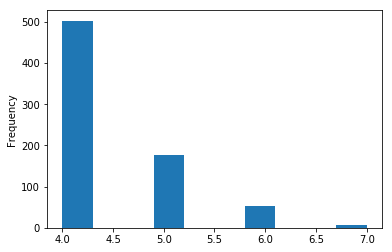

In [79]:
# Histogram binned by eruption size
# Default plots are super easy but not so pretty
df.ExplosivityIndexMax.plot.hist()

Text(0.5,0,'VEI')

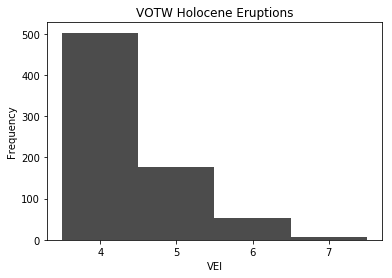

In [105]:
df.ExplosivityIndexMax.plot(kind='hist',
                            bins=[4,5,6,7,8], 
                            xticks=[4,5,6,7], 
                            color='k',
                            title='VOTW Holocene Eruptions',
                            alpha=0.7,
                            align='left',
                           )
plt.xlabel('VEI')

In [ ]:
# Plot them
